In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.ndimage import gaussian_filter

In [2]:
def load_imgs(dir_path):
    imgs = []

    for filename in os.listdir(dir_path):
        if filename.lower().endswith(('.png', '.jpg')):
            img_path = os.path.join(dir_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                imgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else: 
                print(f'failed to load: {img_path}')
    return imgs



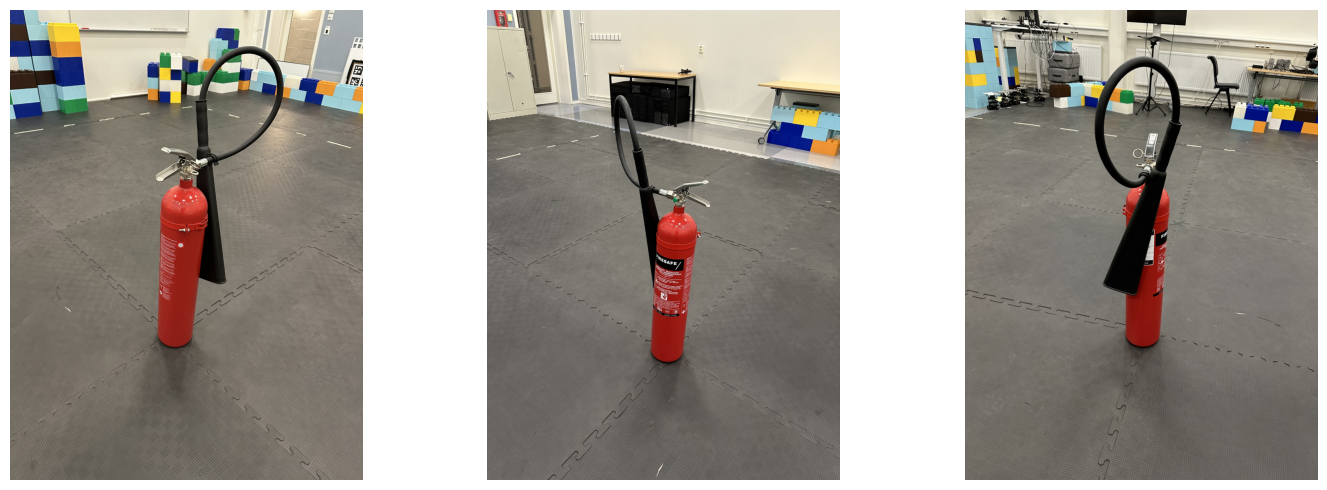

In [5]:
anchor_set = load_imgs('data/Anchor')
image_set = load_imgs('data/camera_color_image_raw')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(anchor_set[i])
    ax.axis('off')


Guassian pyramids, images are blurred and reduced in size (downsampled) a by factor of 2, images are smaller and more blurred than the last

In [14]:
def get_num_octaves(image_shape):
    return int(round(np.log(min(image_shape)) / np.log(2) - 1))


# input image should be already blurred and upscaled by 2 pixels each direction
def get_DoGs(image, sigma, num_scales):
    num_octaves = get_num_octaves(image.shape)


    # Computes the sigma for each level of blur. Instead of blurring each image n times, 
    # we instead compute the kernel that has the same effect, since convolution is slow
    imgs_per_octave = num_scales + 3
    k = 2 ** (1/num_scales)

    kernel_sigmas = np.zeros(imgs_per_octave) 
    kernel_sigmas[0] = sigma

    for i in range(imgs_per_octave):
        sigma_prev = sigma * (k ** i)
        sigma_cur  = sigma_prev * k 
        kernel_sigmas[i] = np.sqrt(sigma_cur ** 2 - sigma_prev ** 2)
    
    print(kernel_sigmas)

    gaussians = []
    for i in range(num_octaves):
        current_octave = []
        current_octave.append(image)
        for _sigma in kernel_sigmas[1:]: # not first one, already added
            image = cv2.GaussianBlur(image, (0, 0), sigmaX = _sigma, sigmaY = _sigma)
            current_octave.append(image)
        gaussians.append(current_octave)

        next_octave_start = current_octave[-3]
        next_img_size = (int(next_octave_start.shape[1] / 2), int(next_octave_start.shape[0] / 2))
        image =  cv2.resize(next_octave_start, next_img_size, interpolation=cv2.INTER_NEAREST)


    DoGs = []

    for current_octave in gaussians:
        DoGs_in_octave = [cv2.subtract(gaussians[i + 1], gaussians[i]) for i in range(len(gaussians) - 1)]
        DoGs.append(DoGs_in_octave)
        
    return DoGs





[1.2262735  1.54500779 1.94658784 2.452547   3.09001559 3.89317568]
[[]]


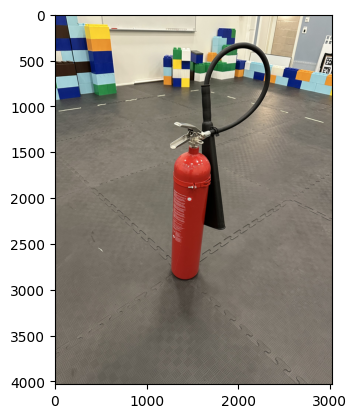

In [16]:
img = anchor_set[0]
plt.imshow(img)
sigma = 1.6

img = cv2.GaussianBlur(img, (0,0), sigmaX = sigma, sigmaY = sigma)
dogs = get_DoGs(img, sigma, 3)
print(dogs)

asdasd

In [6]:

def is_extrema(DoGs, i, y, x): # basically figure 2 of the paper
    # 3x3x3 region to check
    region = np.array([
        DoGs[i + 1][y - 1 : y + 2, x - 1 : x + 2], 
        DoGs[i    ][y - 1 : y + 2, x - 1 : x + 2],
        DoGs[i - 1][y - 1 : y + 2, x - 1 : x + 2]
    ])
    # check if center is max or min, argmax is faster than comparing middle pixel with region.max/min
    return region.argmax() == 13 or region.argmin == 13



asdasdasdasd